We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add FTLE folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FTLE3D")

# add ActiveBarriers folder to current working path
sys.path.append(parent_directory+"/demos/ActiveBarriers")

# Overview

We illustrate the numerical implementation and the use of the active Finite Time Lyapunov Exponent ($ \mathrm{aFTLE} $) on a direct numerical simulation of a turbulent channel flow from the publicly available [Johns Hopkins University Turbulence
Database (JHTDB)](http://turbulence.pha.jhu.edu/). The active LCS diagnostic is applied to the three-dimensional and steady instantaneous linear momentum barrier equation. The notebook is structured as follows:

1. Import Laplacian of velocity-field data stored in the folder 'data/Turbulence'. The Laplacian of the velocity field has been computed from the publicly available John Hopkins University Turbulence Database. The precomputed data has been processed by Dr. Aksamit in his work on identifying uniform momentum barriers [1] and can alternatively be found on [haller-group/TRA_TSE](https://github.com/haller-group/TRA_TSE).

2. Define computational parameters (such as the number of cores) and data.
3. Define spatio-temporal domain.
4. Interpolate Laplacian of velocity from (discrete) gridded data.
5. Instantaneous linear momentum barrier equation active Finite Time Lyapunov Exponent ($ \mathrm{aFTLE} $):

   For 3D incompressible, uniform-density Navier–Stokes flows, the Eulerian barrier equation for linear momentum is:
   
   \begin{equation}
       \mathbf{x'}(s) = \nu \rho \Delta \mathbf{v}(\mathbf{x}, t) \label{eq: linearmoment1} \tag{1}
   \end{equation}
   
   By appropriate rescaling with respect to the dummy time, equation \ref{eq: linearmoment1} simplifies to: 

   \begin{equation}
       \mathbf{x'}(s) = \Delta \mathbf{v}(\mathbf{x}, t) \label{eq: linearmoment2} \tag{2}
   \end{equation}
   
    Time 't' is just a fixed parameter and hence the system is autonomous and the integration is done with respect to a dummy time variable 's'. 's' can be arbitrarily large and the $ \mathrm{aFTLE} $ is only limited by the spatial resolution and domain. It can thus potentially reveal finer and more resolved structures compared to the classic version of the $ \mathrm{FTLE} $, which is fundamentally limited by the temporal domain of the available data.
    
   We start by evaluating the right-hand-side of equation \ref{eq: linearmoment2} by first interpolating $ \Delta \mathbf{v}(\mathbf{x}, t) $ over the spatial meshgrid.
   
   We then apply the $ \mathrm{aFTLE} $ to the autonomous ODE from equation \ref{eq: linearmoment2} over different dummy time-intervals.
6. References

# Import data

In [2]:
# import h5py
import h5py

# import numpy
import numpy as np

f = h5py.File('../../../../data/Turbulence/MomentumBarrierField.mat','r')

lap_U = np.array(f.get('Lap_vx'))
lap_V = np.array(f.get('Lap_vy'))
lap_W = np.array(f.get('Lap_vz'))

lap_U = lap_U.transpose([1,2,0])
lap_V = lap_V.transpose([1,2,0])
lap_W = lap_W.transpose([1,2,0])

x = np.array(f.get('x_span'))
y = np.array(f.get('y_span'))
z = np.array(f.get('z_span'))
y = y.transpose()

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# import numpy
import numpy as np

# Number of cores for parallel computing
Ncores = 4 # int

# Periodic boundary conditions
periodic_x = False # bool
periodic_y = False # bool
periodic_z = False # bool
periodic = [periodic_x, periodic_y, periodic_z]

# Unsteady velocity field
bool_unsteady = False # bool

# Defined domain
defined_domain = np.isfinite(lap_U).astype(int) # array (NY, NX, NZ)

## Compute meshgrid of dataset
X, Y, Z = np.meshgrid(x, y, z) # array (NY, NX), array (NY, NX, NZ)

## Resolution of meshgrid
dx_data = X[0,1,0]-X[0,0,0] # float
dy_data = Y[1,0,0]-Y[0,0,0] # float
dz_data = Y[0,0,1]-Z[0,0,0] # float

delta = [dx_data, dy_data, dx_data] # list (3, )

# auxiliary grid spacing
aux_grid = [0.1*delta[0], 0.1*delta[1], 0.1*delta[2]] # list (3,)

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Time
t0 = 0 # float

# boundaries
xmin = 2.26 # float
xmax = 2.36 # float
ymin = 0.33 # float
ymax = 0.47 # float
z_section = 2.55 # float

assert np.min(X) < xmin < np.max(X), f'xmin must be between {np.min(X)} and {np.max(X)}'
assert np.min(X) < xmax < np.max(X), f'xmax must be between {np.min(X)} and {np.max(X)}'
assert np.min(Y) < ymin < np.max(Y), f'ymin must be between {np.min(Y)} and {np.max(Y)}'
assert np.min(Y) < ymax < np.max(Y), f'ymax must be between {np.min(Y)} and {np.max(Y)}'
assert np.min(Z) < z_section < np.max(Z), f'z_section must be between {np.min(Z)} and {np.max(Z)}'

# Resolution of meshgrid
Ny = 600 # int
Nx = 600 # int

x_domain = np.linspace(xmin, xmax, Nx, endpoint = True) # array (Nx, )
y_domain = np.linspace(ymin, ymax, Ny, endpoint = True) # array (Ny, )

dx = x_domain[1]-x_domain[0] # float
dy = y_domain[1]-y_domain[0] # float

X_domain, Y_domain = np.meshgrid(x_domain, y_domain) # array (Ny, Nx)

# Define dummy time-intervals for computation of aFTLE in ascending order
s1 = 10**(-4) # float s1 > 0
s2 = 0.5*10**(-3) # float s2 > s1
s3 = 10**(-3) # float s3 > s2

s = [s1, s2, s3] # list (3,)

# define dummy time interval
ds = 10**(-5)
sN = s[-1] # Feel free to change this parameter as needed
s_dummy = np.arange(0, sN+ds, ds)

# Interpolate Laplacian of velocity

In order to evaluate the laplacian of the velocity field at arbitrary locations, we interpolate the discrete laplacian of velocity data. The interpolation with respect to space is "linear".

In [5]:
# Import interpolation function for steady flow field
from ipynb.fs.defs.Interpolant import interpolant_steady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
lap_U[np.isnan(lap_U)] = 0
lap_V[np.isnan(lap_V)] = 0
lap_W[np.isnan(lap_W)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_steady(X, Y, Z, lap_U, lap_V, lap_W)

Interpolant_lap_u = Interpolant[0] # RectangularBivariateSpline-object
Interpolant_lap_v = Interpolant[1] # RectangularBivariateSpline-object
Interpolant_lap_w = Interpolant[2] # RectangularBivariateSpline-object

# Instantaneous linear momentum barriers

We visualize linear momentum barriers by applying the $ \mathrm{FTLE} $ to trajectories of instantaneous linear momentum barrier equation \ref{eq: linearmoment2}. As soon as the $ \mathrm{FTLE} $-field is applied to an active vector field, such as linear momentum, we refer to it as $ \mathrm{aFTLE} $ (active $ \mathrm{FTLE} $).

## active FTLE

We now compute the active $ \mathrm{FTLE} $ for the instantaneous linear momentum barrier equation. First, we evaluate the gradient of the active flow map over the meshgrid. The active flow map is given by the solution of the autonomous ODE from equation \ref{eq: linearmoment2}. Finally, we apply the classic $ \mathrm{FTLE} $ to the gradient of the active flow map. The computation of the active $ \mathrm{FTLE} $ is not done over the 3D meshgrid but only over the 2D cross-section.

In [6]:
# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import function to compute finite time Lyapunov exponent (FTLE)
from ipynb.fs.defs.FTLE import _FTLE

# Import package for parallel computing
from joblib import Parallel, delayed

def compute_aFTLE(x0, y0, z0, s_dummy, s):
    
    X0 = np.array([x0, y0, z0]) # array (3, Nx*Ny*Nz)
    
    activeDF = gradient_flowmap(s_dummy, X0, X, Y, Z, Interpolant_lap_u, Interpolant_lap_v, Interpolant_lap_w, periodic, bool_unsteady, aux_grid) # array (Nt, 3, 3, Nx*Ny*Nz)
    
    aFTLE = np.zeros((len(s), activeDF.shape[-1]))
    
    counter = 0
    for idx in np.searchsorted(s_dummy, s):
        
        for i in range(activeDF.shape[3]):
            
            aFTLE[counter, i] = _FTLE(activeDF[idx,:,:,i], s_dummy[idx])
            
        counter += 1
    
    return aFTLE

# Split x0,y0,z0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

In [7]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )
x0 = X_domain.ravel() # array (Nx*Ny, )
y0 = Y_domain.ravel() # array (Nx*Ny, )
z0 = z_section*np.ones(x0.shape[0],) # array (Nx*Ny, )

x0_batch = list(split(x0, Ncores)) # list (Nx*Ny)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny)
z0_batch = list(split(z0, Ncores)) # list (Nx*Ny)
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(compute_aFTLE)(x0_batch[i], y0_batch[i], z0_batch[i], s_dummy, s) for i in range(len(x0_batch)))

# Extract results of aFTLE computation on xy-plane
aFTLE = results[0]
for res in results[1:]:
    aFTLE = np.append(aFTLE, res, axis = -1)
    
X0 = np.array(x0).reshape(Ny,Nx) # array (Ny, Nx)
Y0 = np.array(y0).reshape(Ny,Nx) # array (Ny, Nx)
Z0 = np.array(z0).reshape(Ny,Nx) # array (Ny, Nx)
aFTLE = np.array(aFTLE).reshape(len(s),Ny,Nx) # array (3, Ny, Nx)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 15.7min finished


##### aFTLE over different dummy time-intervals

In the following we visualize the instantaneous linear momentum/vorticity barriers at time $ t_0 = 0 $ through the $ \mathrm{aFTLE} $ over different dummy time-intervals. Ridges of $ \mathrm{aFTLE}_{0,0}^{s_i} \ (i \in \lbrace 1,2,3 \rbrace) $ indicate transport barriers which block the transport of linear momentum. Note that contrary to the classic $ \mathrm{FTLE} $, the $ \mathrm{aFTLE} $ diagnostic is not limited by the temporal domain as the dummy time-interval can be chosen to be arbitrarily large. We explore the structures of the $ \mathrm{aFTLE}_{0,t_0}^{s_i} $ over different dummy time-intervals $ s_i \in \lbrace 1,2,3 \rbrace $ at time $ t_0 $.

In [8]:
# Import matplotlib
import matplotlib.pyplot as plt

# plot iterate over different dummy time-intervals and display aFTLE field calculated over each time-interval
def plot_aFTLE(i):
    
    # create figure
    fig = plt.figure(dpi = 400)
    ax = plt.axes()
    
    # Fontsize
    font_size = 7
    
    # Title
    ax.set_title(r'$ \mathrm{aFTLE}$'+f'$_{{{0}}}^{{{s[i]}}}$', fontsize = font_size)
    
    # Contourplot
    cax = ax.contourf(X_domain, Y_domain, aFTLE[i,:,:], levels = 100, cmap = "gist_rainbow_r")
    
    # Set labels
    ax.set_xlabel("x", fontsize = font_size)
    ax.set_ylabel("y", fontsize = font_size)
    
    # Set ticks
    ax.set_xticks(np.arange(xmin, xmax+0.01, 0.02))
    ax.set_yticks(np.arange(ymin, ymax+0.01, 0.02))
    
    # Set fontsize
    ax.xaxis.set_tick_params(labelsize=font_size)
    ax.yaxis.set_tick_params(labelsize=font_size)
    
    # Colorbar
    cbar = plt.colorbar(cax, format='%.0e')
    cbar.ax.tick_params(labelsize=font_size)
    ax.set_aspect('equal')
    
    plt.show()

##### $ \mathrm{aFTLE}_{0,0}^{s_1} $

Instantaneous linear momentum barriers at time $ t_0 = 0 $ from $ \mathrm{aFTLE}_{0,0}^{s_1} $.

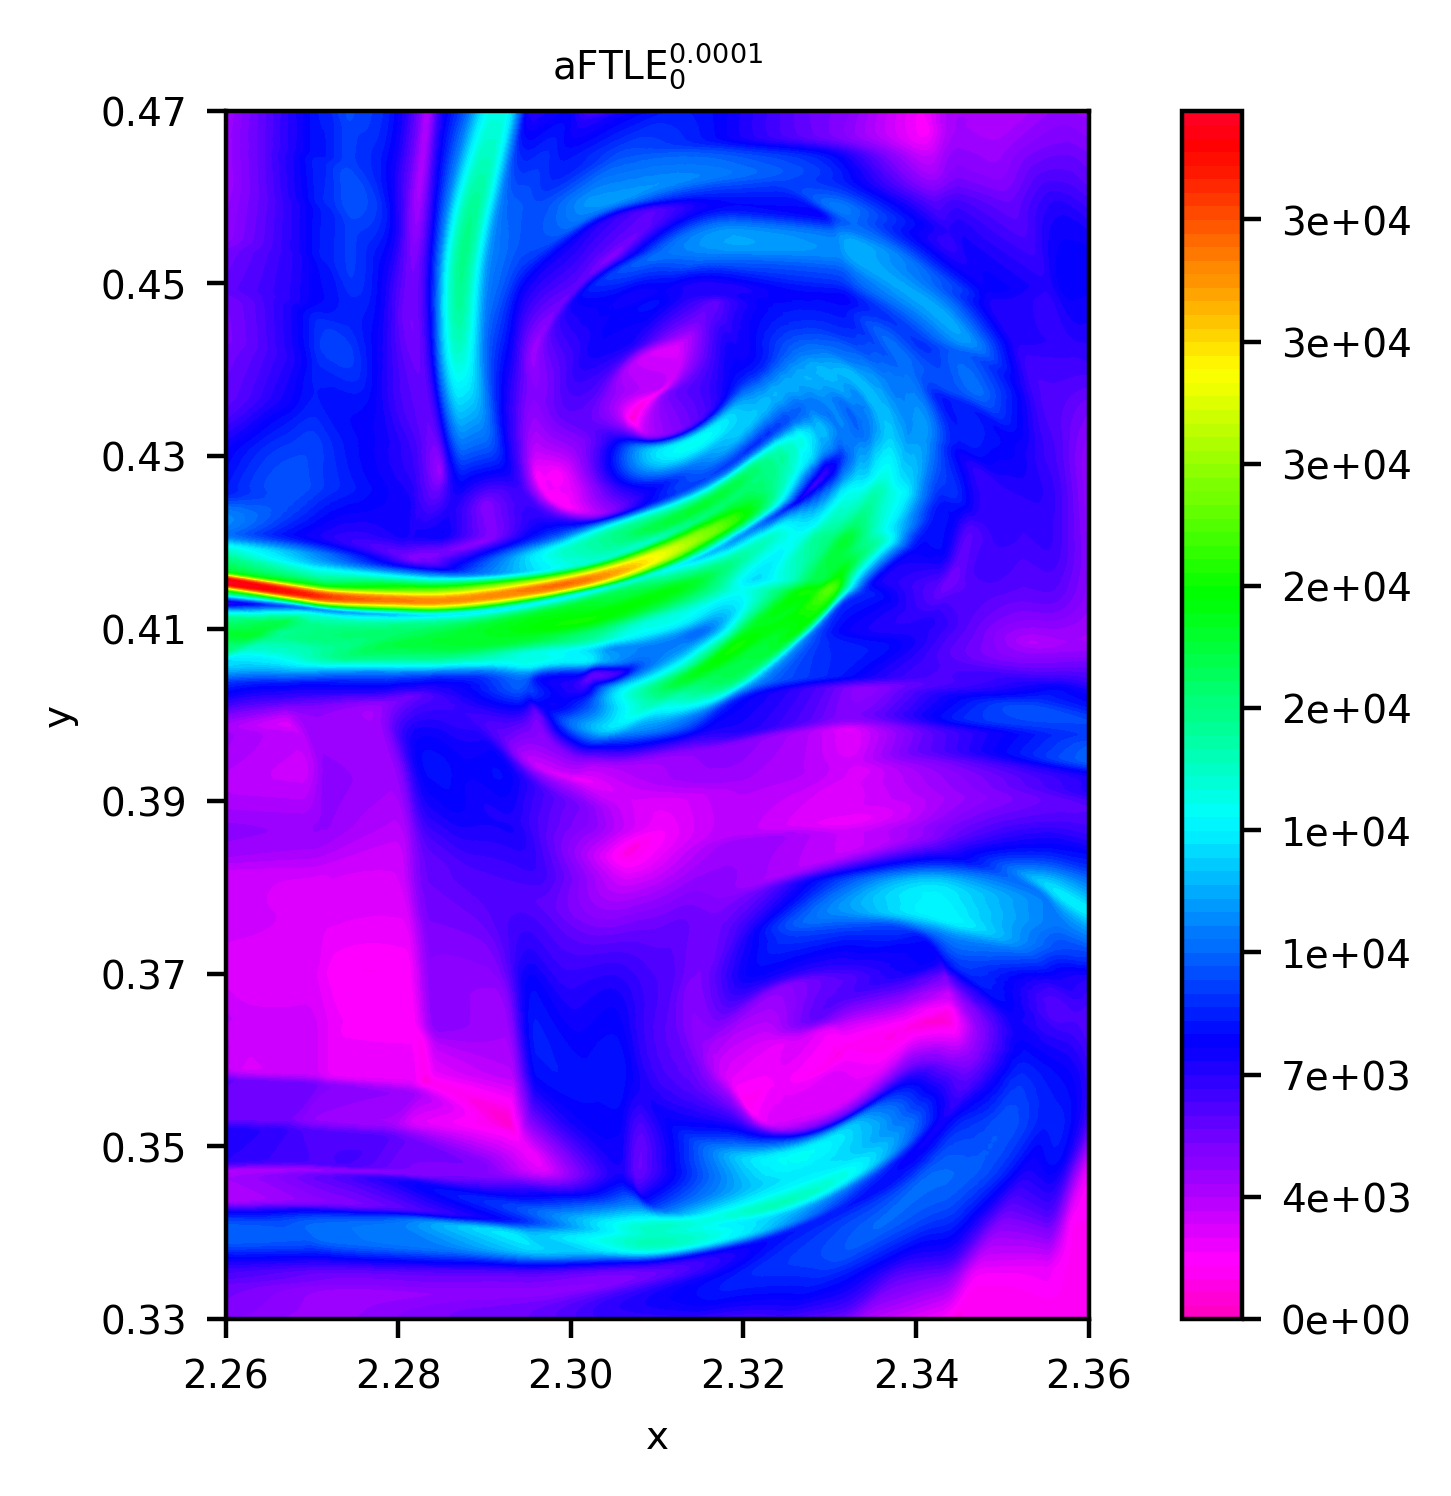

In [9]:
################################################ PLOT RESULTS ################################################
plot_aFTLE(0)

##### $ \mathrm{aFTLE}_{0,0}^{s_2} $

Instantaneous linear momentum barriers at time $ t_0 = 0 $ from $ \mathrm{aFTLE}_{0,0}^{s_2} $.

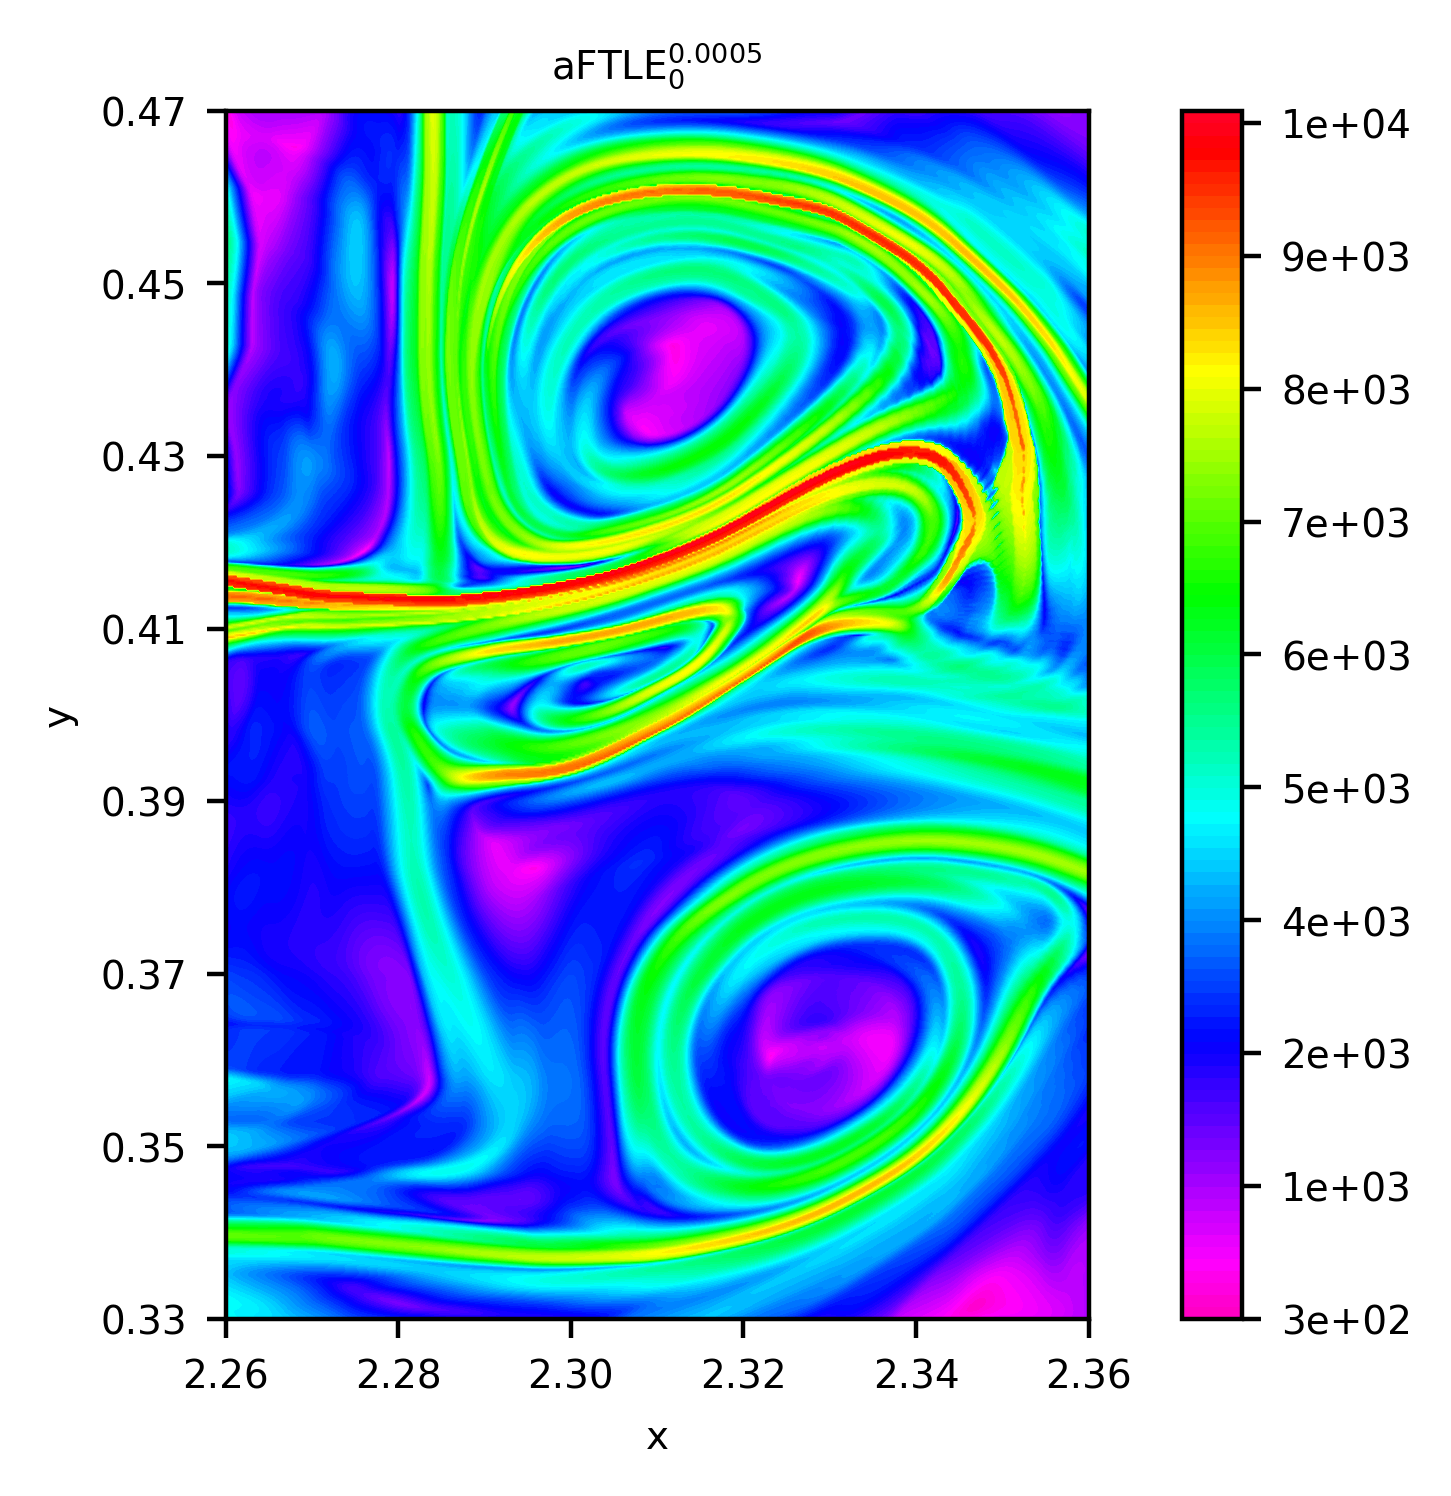

In [10]:
################################################ PLOT RESULTS ################################################
plot_aFTLE(1)

##### $ \mathrm{aFTLE}_{0,0}^{s_3} $

Instantaneous linear momentum barriers at time $ t_0 = 0 $ from $ \mathrm{aFTLE}_{0,0}^{s_3} $.

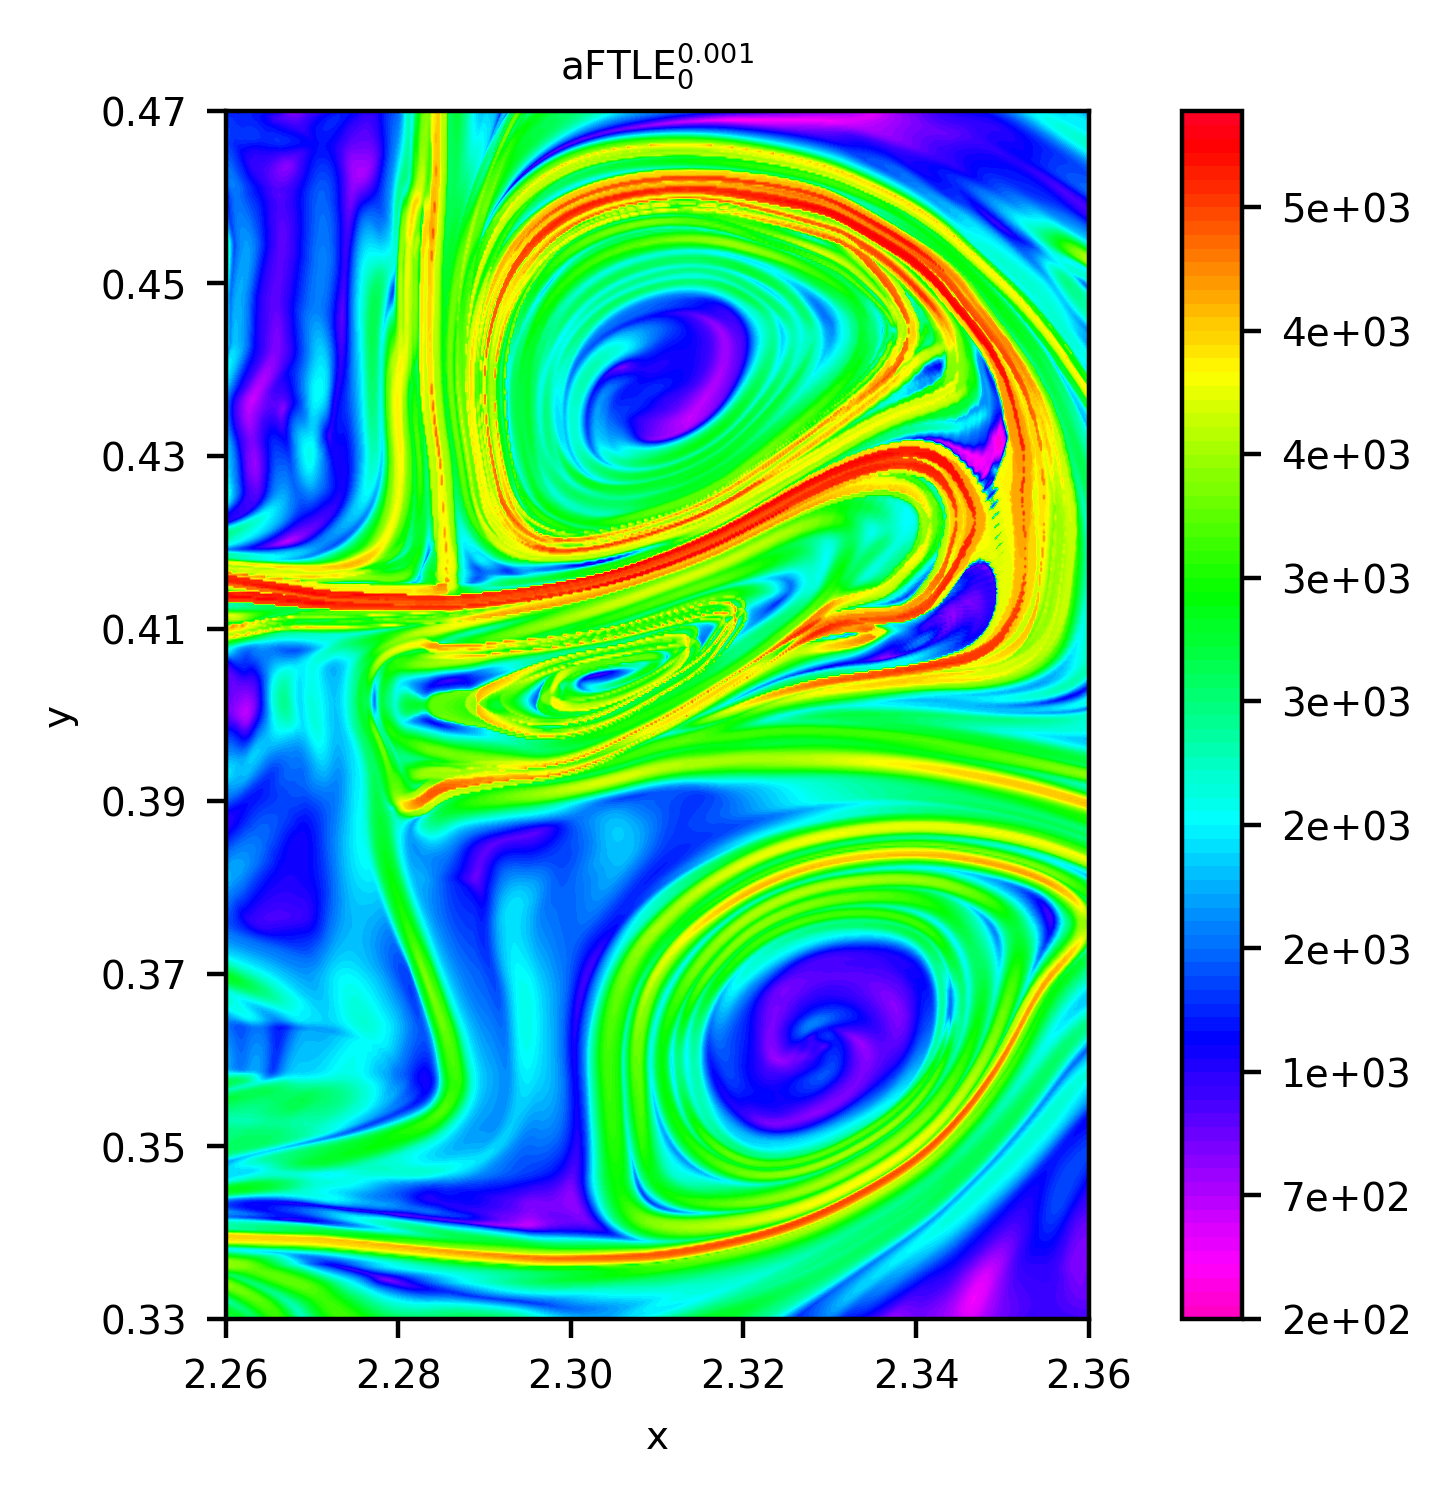

In [11]:
################################################ PLOT RESULTS ################################################
plot_aFTLE(2)

The figures focus on momentum-based active hyperbolic barriers in a section of a 3D turbulent channel flow. In 2D cross-sections of the flow, hyperbolic regions which inhibit the transport of linear momentum can be located as ridges of the $ \mathrm{aFTLE} $-field. The $ \mathrm{aFTLE} $ provides a clear picture of the main vortices and active hyperbolic barriers. The features become even more pronounced for longer s-times, revealing several small scale hyperbolic structures. As the turbulent channel flow is spatially limited, one must be aware that by increasing the dummy time interval, trajectories might leave the domain where the velocity field (and hence also the laplacian of the velocity field) is well defined. Furthermore, it must be taken into account that increasing the dummy time horizon, also emphasizes numerical errors and hence the $ \mathrm{aFTLE} $ become more sensitive to noise.

# References

[1] Haller, G., Katsanoulis, S., Holzner, M., Frohnapfel, B., & Gatti, D. (2020). Objective barriers to the transport of dynamically active vector fields. Journal of Fluid Mechanics, 905.

[2] Aksamit, N.O., & Haller, G. (2022). Objective momentum barriers in wall turbulence. Journal of Fluid Mechanics, 941.

[2] Notebook 9.7.2. in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.